# Neural Style Transfer

## Description
This notebook is an implementation of the style transfer algorithm published by [Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf).

## Instructions
It is highly, highly recommended you execute this notebook in Google Colab, but is not necessary as long as your machine  has no complications with the packages imported below.

Go ahead and run all cells. You will be prompted for the content and style images. I have provided a few in the sourceImages directory but you can use whatever images you want.

As part of the execution, a generatedImages directory will be created/recreated and populated as the model trains. Each new execution of the training loop will wipe and repopulate this directory.

In [ ]:
IN_COLAB = 'google.colab' in str(get_ipython())

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.models as models
from torchvision.utils import save_image
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
from PIL import Image
import io
import os
import re
import shutil

from IPython.core.ultratb import AutoFormattedTB

__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

if IN_COLAB:
  from google.colab import files

In [ ]:
source_image_root = 'sourceImages'

# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512,512)), # O.G. 224 x 224
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  if IN_COLAB:
    file_dict = files.upload()
    content_path = io.BytesIO(file_dict[next(iter(file_dict))])
  else:
    content_path = os.join(source_image_root, input('Enter content image file name (should be in sourceImages directory)'))

  print('\nUpload Style Image')
  if IN_COLAB:
    file_dict = files.upload()
    style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  else:
    content_path = os.join(source_image_root, input('Enter style image file name (should be in sourceImages directory)'))

  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving grogu.png to grogu.png

Upload Style Image


Saving cat.jpg to cat.jpg
Content Path: <_io.BytesIO object at 0x77fb7ff29350>
Style Path: <_io.BytesIO object at 0x77fb7ff29710>


In [ ]:
# After the images are uploaded on to the local filesystem, load them into tensors:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


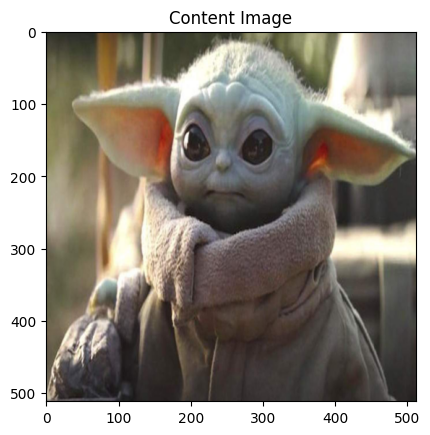

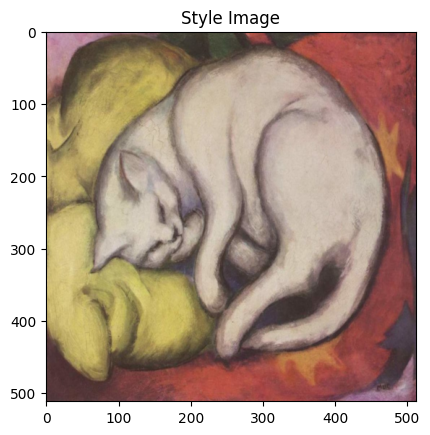

In [ ]:
# Display the images
toPIL = transforms.ToPILImage()

def display(tensor, title=None):
  image = tensor.cpu().clone()
  image = image.squeeze(0)
  image = toPIL(image)
  plt.imshow(image)
  if title is not None:
    plt.title(title)

plt.figure()
display(content_image, title='Content Image')

plt.figure()
display(style_image, title='Style Image')


___

### Part 1
Create the model.



In [ ]:
class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
    super(Normalization, self).__init__()
    self.mean = torch.tensor(mean).view(-1, 1, 1)
    self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
    return (img - self.mean) / self.std

class VGG(nn.Module):
  def __init__(self, requested=[]):
    super(VGG, self).__init__()
    self.norm = Normalization().eval() # from above
    self.requested = requested
    self.model = models.vgg16(pretrained=True).features[:31] # cut off dense layers

  def forward(self, x):
    features = []
    for layer_num, layer in enumerate(self.model):
      x = layer(x)
      if str(layer_num) in self.requested:
        features.append(x)
    return features

In [ ]:
# Choose the layers to use for style and content transfer and instantiate the model
requested_layers = ['0', '5', '10', '17', '24']
model = VGG(requested_layers).to('cuda').eval()


<ipython-input-6-15856e209eba>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-6-15856e209eba>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior

___

### Part 2
Create classes for the style and content loss, as defined in the paper.



In [ ]:
def gram_matrix(input):
  batch_size, channel, height, width = input.shape
  return input.view(channel, height * width).mm(input.view(channel, height * width).t())

def mse(x_1, x_2):
  return torch.mean((x_1 - x_2) ** 2)


class ContentLoss(nn.Module):
  def __init__(self, generated_features, content_features):
    self.loss = 0
    for generated_feature, content_feature in zip(generated_features, content_features):
      self.loss += mse(generated_feature, content_feature) / 2

  def getLoss(self):
    return self.loss


class StyleLoss(nn.Module):
  def __init__(self, generated_features, style_features, use_constant=False):
    self.loss = 0
    for generated_feature, style_feature in zip(generated_features, style_features):
      G = gram_matrix(generated_feature)
      A = gram_matrix(style_feature)

      constant = 1.0
      if use_constant:
        constant = (4 * len(style_feature[0] * len(style_feature[0][0] * len(style_feature[0][0][0])))) ** -1

      self.loss += mse(G, A) * constant
    self.loss /= len(style_features)

  def getLoss(self):
    return self.loss


___

### Part 3
Train the model and show the results!



In [ ]:
# Start with a copy of the content image
generated_image = content_image.clone().requires_grad_(True)

#  Run the optimizer on the images to change the image
#  using the loss of the style and content layers
#  to backpropagate errors

# these are the training params.
total_steps = 500  # 1000 layers takes ~5 min.
learning_rate = 0.1
alpha = 1.
beta = 0.3
optimizer = optim.Adam([generated_image], lr=learning_rate)

# istantiate the progress bar
loop = tqdm(total=total_steps, position = 0)

# util params for work inside the training loop
content_losses = []
style_losses = []
total_losses = []
count = 0

# wipe generatedImages dir
generated_images_dir = 'generatedImages'
if os.path.exists(generated_images_dir):
  shutil.rmtree(generated_images_dir)
os.mkdir(generated_images_dir)

# training loop
for step in range(total_steps):
  generated_features = model(generated_image)
  content_features = model(content_image)
  style_features = model(style_image)

  content_loss = ContentLoss(generated_features, content_features)
  style_loss = StyleLoss(generated_features, style_features, use_constant=True)
  total_loss = alpha * content_loss.getLoss() + beta * style_loss.getLoss()

  # track losses every 50 steps
  if step % 50 == 0:
    content_losses.append(content_loss.getLoss().item())
    style_losses.append(style_loss.getLoss().item())
    total_losses.append(total_loss.item())

  # generate and save an image every 100 steps
  if step % 100 == 0:
    generated_image_name = f'generated{count}.png'
    save_image(generated_image, generated_image_name)
    shutil.move(generated_image_name, generated_images_dir + '/' + generated_image_name)
    count += 1

  # update progress bar
  loop.set_description('step:{} '.format(step))
  loop.update(1)

  # backprop
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

loop.close()

# save a final image
generated_image_name = f'generated{count}.png'
save_image(generated_image, generated_image_name)
shutil.move(generated_image_name, generated_images_dir + '/' + generated_image_name)


step:499 : 100%|██████████| 500/500 [02:17<00:00,  3.63it/s]


'generatedImages/generated5.png'

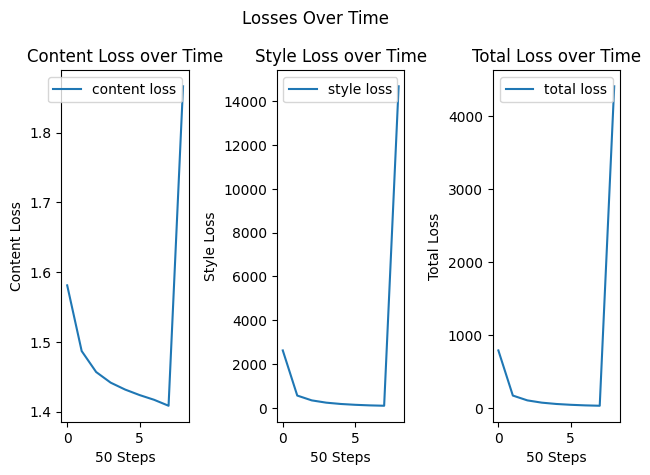

In [ ]:
# plot lossses

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True) #, figsize=(12, 6))

ax0.set_title('Content Loss over Time')
ax0.set_xlabel('50 Steps')
ax0.set_ylabel('Content Loss')
ax0.plot(content_losses[1:], label='content loss')
ax0.legend()

ax1.set_title('Style Loss over Time')
ax1.set_xlabel('50 Steps')
ax1.set_ylabel('Style Loss')
ax1.plot(style_losses[1:], label='style loss')
ax1.legend()

ax2.set_title('Total Loss over Time')
ax2.set_xlabel('50 Steps')
ax2.set_ylabel('Total Loss')
ax2.plot(total_losses[1:], label='total loss')
ax2.legend()

fig.suptitle('Losses Over Time')
plt.tight_layout()
plt.show()

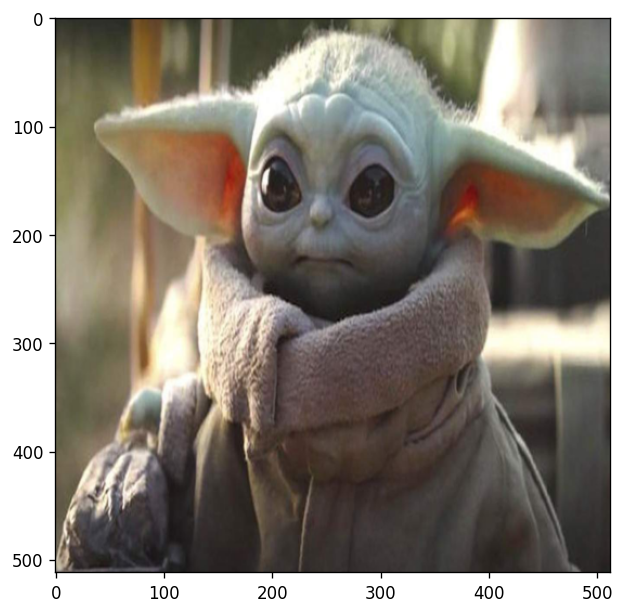

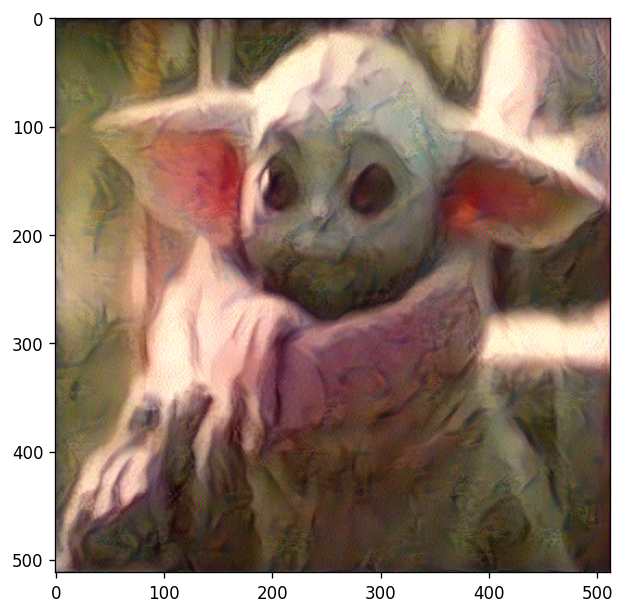

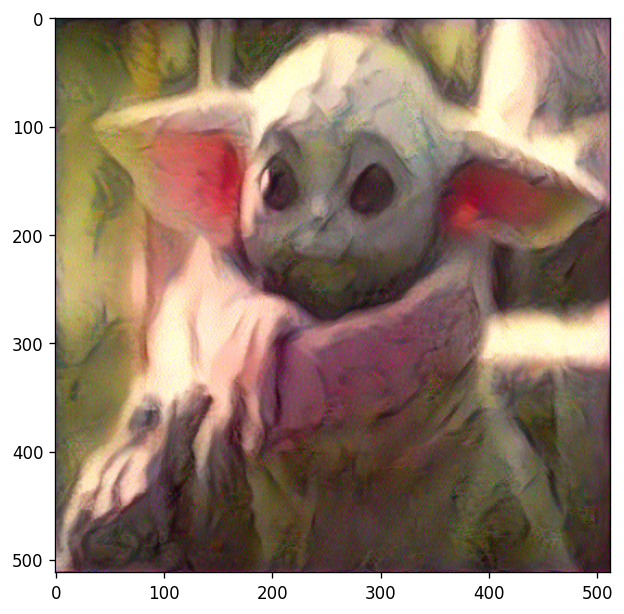

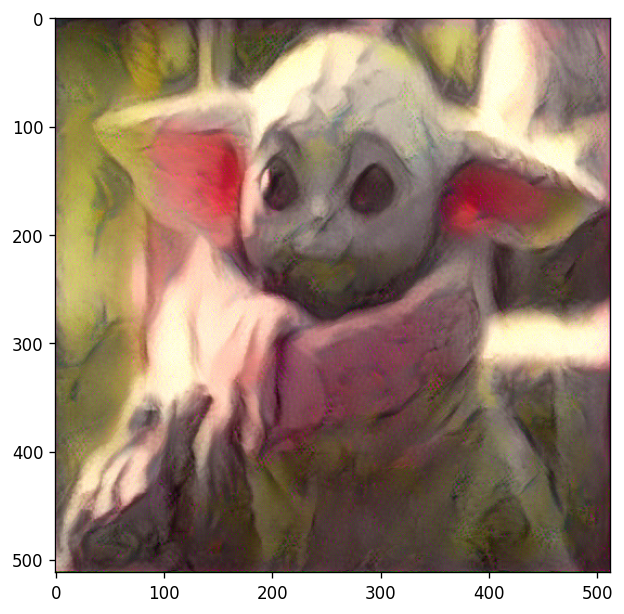

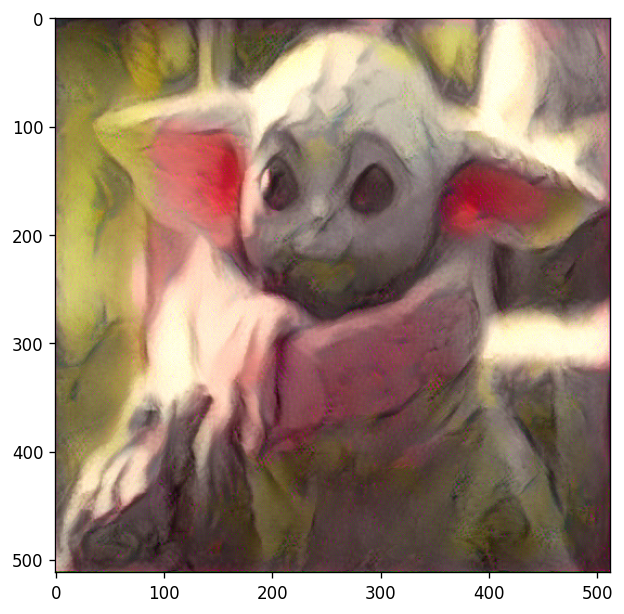

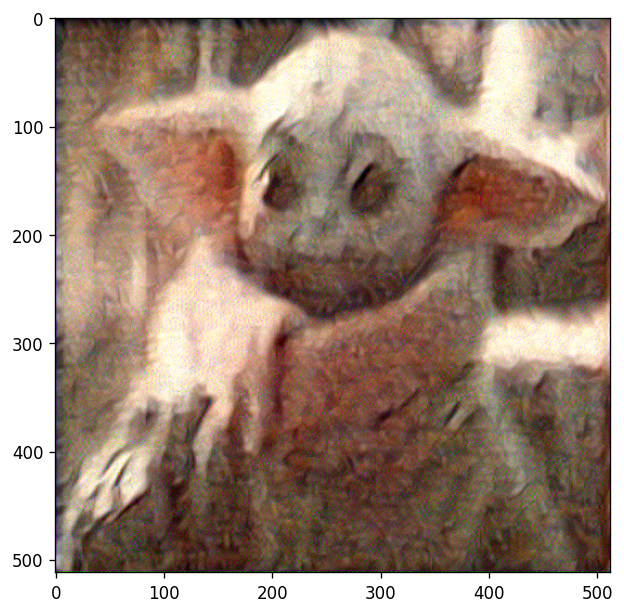

In [ ]:
# Show the generated images

for _, _, filenames in os.walk(generated_images_dir):
  filenames.sort() # only works for generated 0-9
  for filename in filenames:
    if re.search("^generated\d+\.png$", filename):
      fig = plt.figure(figsize=(8, 6), dpi=120)
      image = plt.imread(os.path.join(generated_images_dir, filename))
      plt.imshow(image)


## Final Word
The best generated images are typically the ones associated with the lowest loss. I've provided the generated Images directory so that you can save the one(s) you want, if you'd like.